<u> <h1> Capstone Project to Find the best Rent location </h1> </u>

<h1> <b> Introduction: </b> </h1>

Mr. John is re-locating to Bangalore, India along with his family. He is looking for a suitable accommodation for rent. He has 4 preferred locations in Bangalore, which are: 
<br> a.	Yelahanka.
<br> b.	White Field. 
<br> c.	Banashankari.
<br> d.	Hebbal.
<br>

He is willing to rent a house in any of these 4 locations. Provided, all the below conditions should be  satisfied.
<br> 1) As he is a Foodie, he is looking for nice <b> Restaurants </b>.
<br> 2) He needs a departmental <b> Stores </b> or a Super Market.
<br> 3) A Metro/Bus/Train <b> Station </b>. 
<br> 4) He needs a <b> Park </b> in his neighbourhood, for his relaxation.
<br> 5) He is very much interested in workouts, and needs a full equipped <b> Gym </b>

<h1> Data Source: </h1>
This project will utilize data from <b> Foursquare </b>. Foursquare is a technology company that built a massive dataset of location data. What is interesting about Foursquare is that they were very smart about building their dataset. They actually crowd-sourced their data and had people use their app to build their dataset and add venues and complete any missing information they had in their dataset. Currently its location data is the most comprehensive out there, and quite accurate that it powers location data for many popular services like Apple Maps, Uber, Snapchat, Twitter and many others, and is currently being used by over 100,000 developers, and this number is only growing.

The data returned from Foursquare API includes many information about restaurants including latitude, longitude, distance from search point, city, province, complete address, business category etc.

<h1> Target/ Expected result: </h1>
At the end of this project, we should be able to suggest best Rent location to the user, which fulfills all his demands

<h1> Import all the necessary libraries needed to accomplish this task </h1>

In [2]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import folium
import re

print('Libraries imported!')

Libraries imported!


<h1> Get the Latitude and Longitudes of user's Location preferences </h1>

<i> Locations: Hebbal, Yelahanka, Banashankari, Whitefield </i>

In [3]:
locations_list=['Hebbal','Yelahanka','Banashankari, Bengaluru','Whitefield, Bengaluru']
lst=[]
for locs in locations_list:
    geolocator = Nominatim(user_agent="india")
    location = geolocator.geocode(locs)
    latitude = location.latitude
    longitude = location.longitude
    lst.append([locs, latitude, longitude])
    locations_df = pd.DataFrame(lst)

locations_df.columns=['Location', 'Latitude', 'Longitude']

#Print the result set
locations_df

,Location,Latitude,Longitude
0,Hebbal,13.038218,77.591900
1,Yelahanka,13.100698,77.596345
2,"Banashankari, Bengaluru",12.915221,77.573598
3,"Whitefield, Bengaluru",12.969637,77.749745


<h1> Use Foursquare API to get the neighborhood Venues of the locations </h1>

In [4]:
CLIENT_ID = 'C1JNHEQHTCG15GV1A2R2SMAJAFLLXLOK2YTRXHHP0PXRPQFY' # Foursquare ID
CLIENT_SECRET = 'OCOZETGZD5U2ALI2TR2UZFXF4Y0KN0RY0I0RFKWN0UEVHSNB' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 300 # limit of number of venues returned by Foursquare API
radius = 6000 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=C1JNHEQHTCG15GV1A2R2SMAJAFLLXLOK2YTRXHHP0PXRPQFY&client_secret=OCOZETGZD5U2ALI2TR2UZFXF4Y0KN0RY0I0RFKWN0UEVHSNB&v=20180605&ll=12.9696365,77.7497448&radius=6000&limit=300'

In [5]:
results = requests.get(url).json()

In [6]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [7]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=3000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
        print(url)   
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h1> Get all the URLs for the desired locations </h1>

In [9]:
bang_venues = getNearbyVenues(names=locations_df['Location'],
                                   latitudes=locations_df['Latitude'],
                                   longitudes=locations_df['Longitude']
                                  )
bang_venues.columns= ['Location','Neighborhood_Latitude','Neighborhood_Longitude','Venue','Venue_Latitude','Venue_Longitude','Venue_Category']

Hebbal
https://api.foursquare.com/v2/venues/explore?&client_id=C1JNHEQHTCG15GV1A2R2SMAJAFLLXLOK2YTRXHHP0PXRPQFY&client_secret=OCOZETGZD5U2ALI2TR2UZFXF4Y0KN0RY0I0RFKWN0UEVHSNB&v=20180605&ll=13.0382184,77.5919&radius=3000&limit=100
Yelahanka
https://api.foursquare.com/v2/venues/explore?&client_id=C1JNHEQHTCG15GV1A2R2SMAJAFLLXLOK2YTRXHHP0PXRPQFY&client_secret=OCOZETGZD5U2ALI2TR2UZFXF4Y0KN0RY0I0RFKWN0UEVHSNB&v=20180605&ll=13.1006982,77.5963454&radius=3000&limit=100
Banashankari, Bengaluru
https://api.foursquare.com/v2/venues/explore?&client_id=C1JNHEQHTCG15GV1A2R2SMAJAFLLXLOK2YTRXHHP0PXRPQFY&client_secret=OCOZETGZD5U2ALI2TR2UZFXF4Y0KN0RY0I0RFKWN0UEVHSNB&v=20180605&ll=12.9152208,77.573598&radius=3000&limit=100
Whitefield, Bengaluru
https://api.foursquare.com/v2/venues/explore?&client_id=C1JNHEQHTCG15GV1A2R2SMAJAFLLXLOK2YTRXHHP0PXRPQFY&client_secret=OCOZETGZD5U2ALI2TR2UZFXF4Y0KN0RY0I0RFKWN0UEVHSNB&v=20180605&ll=12.9696365,77.7497448&radius=3000&limit=100


<h1> Filter the Venue Categories based on the preferences of the user </h1>

<i> User Preferences of Neighborhood: Should have Restaurant, Gym, Park, Stores and Metro/Bus Station </i>

In [11]:
bang_venues = bang_venues[bang_venues['Venue_Category'].str.contains('Restaurant|Gym|Fitness||Park|Department|Store|Metro|Bus|Station')==True].sort_values(["Venue_Latitude","Venue_Longitude"]).groupby(["Location","Venue_Category"], as_index=False).first()

<h1> Convert the Location Strings to Numeric Codes, so that they are ready to be used in maps </h1>

In [26]:
def map_values(row, values_dict):
    return values_dict[row]

values_dict = {'Hebbal': 1, 'Whitefield, Bengaluru': 2, 'Banashankari, Bengaluru': 3, 'Yelahanka': 4}

df = pd.DataFrame({'Locations': ['Hebbal', 'Whitefield, Bengaluru', 'Banashankari, Bengaluru', 'Yelahanka'], 'VALUE': [1, 2, 3, 4]})

bang_venues["Location_codes"] = bang_venues['Location'].apply(map_values, args = (values_dict,))

#print sample Resultset
bang_venues

,Location,Venue_Category,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Location_codes
0,"Banashankari, Bengaluru",Andhra Restaurant,12.915221,77.573598,Nagarjuna,12.932892,77.584087,3
1,"Banashankari, Bengaluru",Bakery,12.915221,77.573598,Take A Break,12.906278,77.588863,3
2,"Banashankari, Bengaluru",Bistro,12.915221,77.573598,Café Toscano,12.937024,77.585080,3
3,"Banashankari, Bengaluru",Bookstore,12.915221,77.573598,Sapna Book House,12.930729,77.581554,3
4,"Banashankari, Bengaluru",Boutique,12.915221,77.573598,Fab India,12.937258,77.585245,3
5,"Banashankari, Bengaluru",Breakfast Spot,12.915221,77.573598,The Egg Factory,12.906303,77.590391,3
6,"Banashankari, Bengaluru",Brewery,12.915221,77.573598,Brewsky,12.906521,77.589604,3
7,"Banashankari, Bengaluru",Burger Joint,12.915221,77.573598,Tree Shade,12.906870,77.563343,3
8,"Banashankari, Bengaluru",Café,12.915221,77.573598,Cafe Pascucci,12.906439,77.591836,3
9,"Banashankari, Bengaluru",Chinese Restaurant,12.915221,77.573598,Fujian on 24th,12.903671,77.585865,3


<h1> Plot the map to show the Neighborhood of each location </h1>

In [27]:
# create map
clusters=5
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusters)
ys = [i + x + (i*x) for i in range(clusters)]
colors_array = cm.rainbow(np.linspace(0, 4, len(ys)*6))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bang_venues['Venue_Latitude'], bang_venues['Venue_Longitude'], bang_venues['Location'], bang_venues['Location_codes']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

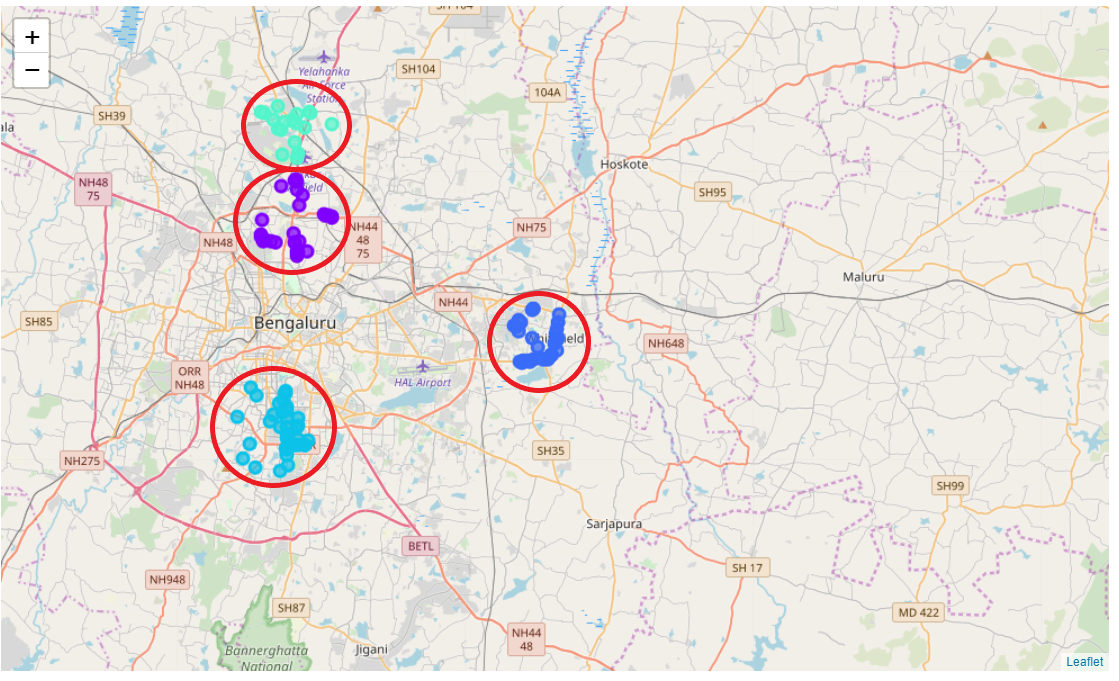

In [32]:
from IPython.display import display, Image
display(Image(filename='Clusters.png'))

<h1> Create a new dataframe to cleanse the Categories, which are not required by the user </h1>

In [16]:
new_df = bang_venues
new_df = new_df[new_df['Venue_Category'].isin(['Motorcycle Shop','Ice Cream Shop','Café','Hookah Bar']) == False]

<h1> Create a dataframe which will categorize the venues based on the nature of the category</h1>

<i> Example: "Indian Restaurant" or "South Indian Restaurant" or "Hyderabadi Restaurant", all fall under and the same category of <b> “Restaurants"</b> </i>

In [18]:
column_names=[]
grouped_df  = pd.DataFrame(columns = column_names)

In [19]:
rest_df = new_df['Venue_Category'].str.contains('Restaurant', re.IGNORECASE).groupby(new_df['Location']).sum()
grouped_df = grouped_df.append(rest_df)
as_list = grouped_df.index.tolist()
idx = as_list.index('Venue_Category')
as_list[idx] = 'Restaurants'
grouped_df.index = as_list
store_df = new_df['Venue_Category'].str.contains('Store', re.IGNORECASE).groupby(new_df['Location']).sum()
grouped_df = grouped_df.append(store_df)
as_list = grouped_df.index.tolist()
idx = as_list.index('Venue_Category')
as_list[idx] = 'Stores'
grouped_df.index = as_list
park_df = new_df['Venue_Category'].str.contains('Park', re.IGNORECASE).groupby(new_df['Location']).sum()
grouped_df = grouped_df.append(park_df)
as_list = grouped_df.index.tolist()
idx = as_list.index('Venue_Category')
as_list[idx] = 'Parks'
grouped_df.index = as_list
lake_df = new_df['Venue_Category'].str.contains('Station', re.IGNORECASE).groupby(new_df['Location']).sum()
grouped_df = grouped_df.append(lake_df)
as_list = grouped_df.index.tolist()
idx = as_list.index('Venue_Category')
as_list[idx] = 'Bus/Railway/Metro Station'
grouped_df.index = as_list
gym_df = new_df['Venue_Category'].str.contains('Gym', re.IGNORECASE).groupby(new_df['Location']).sum()
grouped_df = grouped_df.append(gym_df)
as_list = grouped_df.index.tolist()
idx = as_list.index('Venue_Category')
as_list[idx] = 'Gym'
grouped_df.index = as_list

#Print the resultset
grouped_df

,"Banashankari, Bengaluru",Hebbal,"Whitefield, Bengaluru",Yelahanka
Restaurants,13.0,5.0,15.0,4.0
Stores,2.0,1.0,1.0,1.0
Parks,1.0,1.0,0.0,0.0
Bus/Railway/Metro Station,0.0,1.0,0.0,2.0
Gym,2.0,1.0,2.0,1.0


<h1> Convert the actual count of Venues to 1 or 0 Values </h1>

In [24]:
venue_df = grouped_df
for row in grouped_df:
    for cols in range(5):
        if grouped_df[row][cols] > 0:
            venue_df[row][cols] =1
        else:
            venue_df[row][cols]=0
        
#Reset the index and rename the column 
venue_df=venue_df.reset_index()
venue_df.rename(columns={'index':'Preferences'},inplace=True)

<h1> Since the location "Hebbal" has all the preferences satisfied, it will be the suggested location to the user </h1>

In [25]:
#Print the resultset
venue_df

,Preferences,"Banashankari, Bengaluru",Hebbal,"Whitefield, Bengaluru",Yelahanka
0,Restaurants,1.0,1.0,1.0,1.0
1,Stores,1.0,1.0,1.0,1.0
2,Parks,1.0,1.0,0.0,0.0
3,Bus/Railway/Metro Station,0.0,1.0,0.0,1.0
4,Gym,1.0,1.0,1.0,1.0
